# Circle Loss MNISTでの実験
- [github](https://github.com/TinyZeaMays/CircleLoss/blob/master/mnist_example.py)のLossを使う
- ネットワークは本当に簡単なものを使用
- 分類モデルはロジスティックとlightgbm
- 評価指標はaccuracy, macro平均のprecision, confusion matrixの可視化

In [1]:
import sys
sys.path.append("../src")
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim.lr_scheduler as lr_scheduler
from torch import optim
 
from circle_loss import convert_label_to_similarity, CircleLoss
from classification import create_classification_dataset, plot_confusion_matrix, lr, lightgbm
from mnist import get_mnist_loader
from nn_model import Model, train
from visualize import create_embedding, visualize

In [2]:
use_cuda = torch.cuda.is_available() and True
device = torch.device("cuda" if use_cuda else "cpu")

In [3]:
# train data loader
train_loader = get_mnist_loader(is_train=True, batch_size=64)
# valid data loader
val_loader = get_mnist_loader(is_train=False, batch_size=1)

In [4]:
# model
model = Model().to(device)
# model_path = "../model/mnist_full/model.pth"
# model.load_state_dict(torch.load(model_path)) 

# optimzer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)
sheduler = lr_scheduler.StepLR(optimizer, 20, gamma=0.8)
 
# CircleLoss
criterion = CircleLoss(m=0.25, gamma=80).to(device)
 
# Training
for epoch in range(20):
    sheduler.step()
    train(model, criterion, optimizer, epoch+1, train_loader, device)

/Users/kenta_suzuki/opt/miniconda3/envs/pytorch36/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  1%|          | 5/938 [00:00<00:19, 48.05it/s]

Training... Epoch = 1


  1%|          | 6/938 [00:00<00:16, 55.16it/s]

Training... Epoch = 2


  1%|          | 6/938 [00:00<00:17, 51.81it/s]

Training... Epoch = 3


  1%|          | 6/938 [00:00<00:17, 53.69it/s]

Training... Epoch = 4


  1%|          | 5/938 [00:00<00:18, 49.85it/s]

Training... Epoch = 5


  1%|          | 6/938 [00:00<00:17, 52.49it/s]

Training... Epoch = 6


  1%|          | 5/938 [00:00<00:21, 43.00it/s]

Training... Epoch = 7


  1%|          | 6/938 [00:00<00:18, 49.65it/s]

Training... Epoch = 8


  1%|          | 6/938 [00:00<00:16, 54.90it/s]

Training... Epoch = 9


  1%|          | 6/938 [00:00<00:17, 52.84it/s]

Training... Epoch = 10


  1%|          | 6/938 [00:00<00:17, 53.38it/s]

Training... Epoch = 11


  1%|          | 6/938 [00:00<00:17, 52.56it/s]

Training... Epoch = 12


  1%|          | 6/938 [00:00<00:18, 50.84it/s]

Training... Epoch = 13


  1%|          | 6/938 [00:00<00:17, 54.40it/s]

Training... Epoch = 14


  1%|          | 6/938 [00:00<00:17, 54.07it/s]

Training... Epoch = 15


  1%|          | 6/938 [00:00<00:17, 52.65it/s]

Training... Epoch = 16


  1%|          | 6/938 [00:00<00:17, 54.44it/s]

Training... Epoch = 17


  1%|          | 5/938 [00:00<00:19, 48.58it/s]

Training... Epoch = 18


  1%|          | 6/938 [00:00<00:17, 54.58it/s]

Training... Epoch = 19


  1%|          | 6/938 [00:00<00:17, 53.61it/s]

Training... Epoch = 20


100%|██████████| 938/938 [00:16<00:00, 55.29it/s]


In [5]:
model_path = "../model/mnist_full/model.pth"
torch.save(model.to('cpu').state_dict(), model_path)

分類モデルに投入するためのデータセット作成

In [6]:
train_x, train_y = create_classification_dataset(train_loader, model, device)
valid_x, valid_y = create_classification_dataset(val_loader, model, device)

100%|██████████| 10000/10000 [00:05<00:00, 1908.35it/s]


埋め込みの可視化
- とても綺麗にまとまってる...

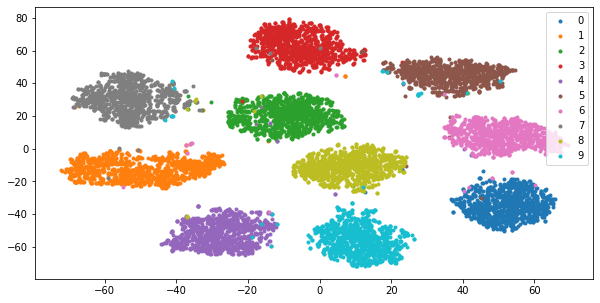

In [7]:
embedding = create_embedding(valid_x, n_components=2, init='pca', random_state=501, metric='cosine')
visualize(embedding, valid_y, 10)

train acc:  0.99505
valid acc:  0.9894
macro mean precision:  0.9892987211652053
macro mean recall:  0.9892812098253831


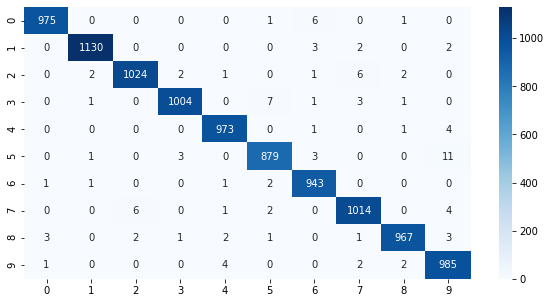

In [8]:
clf = lr(train_x, train_y, valid_x, valid_y)

train acc:  1.0
valid acc:  0.9893
macro mean precision:  0.9891931327185712
macro mean recall:  0.9891531204540011


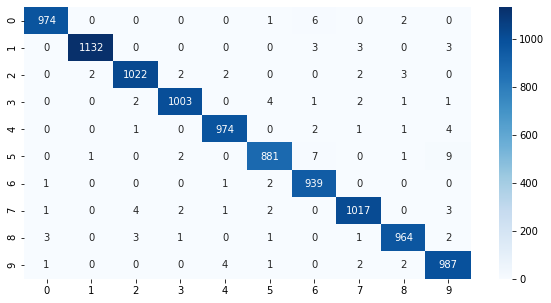

In [9]:
gbm = lightgbm(train_x, train_y, valid_x, valid_y)